# Finding Shaker table sync cues in ACC measurements from Equivitals

having issues with datetime 
https://pandas.pydata.org/docs/whatsnew/v2.2.0.html#datetimelike

https://github.com/pandas-dev/pandas/issues/52895
Work around for now: plt.plot(df.col_in_dt,df.col_signal)

For now, convert all datetimes to utc with .tz_localize(None), .dt.tz_localize(None), and custom remove_tz_from_dataframe function

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
pip show pandas | grep Version

Version: 2.2.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [4]:
%reload_ext autoreload

In [5]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

def xcov(datax, datay,maxlag=10):
    # https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    rs = []
    for i in range(-maxlag,maxlag):
        rs.append(datax.corr(datay.shift(i)))
    return rs

In [6]:
def min_align(ACC,cue,prelim_synch_time,max_offs):   
    sampleshift_s = cue['sTime'].diff().median()
    sf = np.round(1/sampleshift_s)
    t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
    c_type = 'taps'
    xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
              pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
#     print(xrange)
    sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
    cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

    max_offs = 5
    X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
    sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
    sig_v = X['signal']
    f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
    new_sig = f(sig_sTime)
    signal = pd.DataFrame()
    signal.loc[:,'signal'] = new_sig
    signal.loc[signal['signal'].isna(),'signal'] = 0
    # scale signals a little 
    M = signal['signal'].quantile(0.998)
    signal.loc[:,'signal']  = signal['signal']/M
    signal.loc[signal['signal']>1,'signal'] = 1
    signal.loc[signal['signal']<0,'signal'] = 0
    signal.loc[:,'sTime'] = sig_sTime
    signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
    length = np.min([len(signal),len(cue)]) # they should match, but just in case

    xcorred = pd.DataFrame()
    max_offs = 5
    xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
    xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
    max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
    max_r = xcorred['r'].max()
    cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

    fig, axes = plt.subplots(3,1,figsize=(12,4))
    ax =axes[0]
    cue.plot(x='sTime',y=c_type,ax=ax)
    signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
    ax.set_title('ACC synch alignment')
    ax.set_ylabel('Unaligned')
    ax.legend()

    ax = axes[1]
    xcorred.plot(x='shift_s',y='r',ax=ax)
    ax.plot(max_shift,max_r,'ro')
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.set_xticklabels('')

    ax = axes[2]
    ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
    ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
    ax.xaxis.set_tick_params(rotation=40)

    ax.grid(True)
    ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
    ax.set_ylabel('Aligned')
    ax.set_xlabel('dev_Time')
    plt.show()

    cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
    C_results = {'best_dt': cue_time,'best_s': max_shift,'best_r': max_r,'CCC':xcorred,'cue':cue,'signal':signal}
    return C_results

# Get the cues for Friday March 8th

In [7]:
synch_times = {}

In [38]:
cue_times = pd.read_csv('./outfiles/cue1_20240308.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
Sync_Zero_Time_s = cue_times.loc[cue_times['peaks']==1,'S_AudioTime'].iloc[0]
Sync_Zero_Time_dt = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
synch_times['cue1_20240308'] = Sync_Zero_Time_dt
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

22.625397    0.0000
24.779048    2.1536
27.098141    4.4727
29.121179    6.4958
Name: SyncTime, dtype: float64

In [39]:
cue_times = pd.read_csv('./outfiles/cue1_20240308.csv',index_col = 0) #SV alignment for beeps

cue_times

,rms,peaks,DateTime
21.000000,0.000152,0,2024-03-08 06:49:51+00:00
21.002902,0.000174,0,2024-03-08 06:49:51.002902494+00:00
21.005805,0.000265,0,2024-03-08 06:49:51.005804989+00:00
21.008707,0.000257,0,2024-03-08 06:49:51.008707483+00:00
21.011610,0.000250,0,2024-03-08 06:49:51.011609977+00:00
...,...,...,...
29.986122,0.000316,0,2024-03-08 06:49:59.986122449+00:00
29.989025,0.000329,0,2024-03-08 06:49:59.989024943+00:00
29.991927,0.000273,0,2024-03-08 06:49:59.991927438+00:00
29.994830,0.000217,0,2024-03-08 06:49:59.994829932+00:00


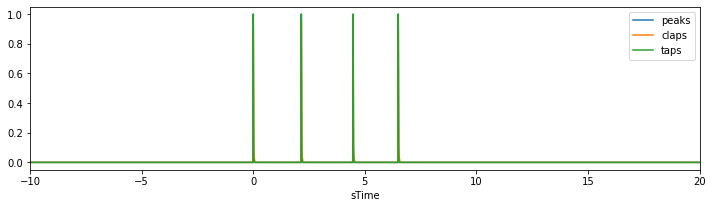

In [40]:
CueT={}
sf = 256
t_range= [-10,20]
cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim(t_range)

CueT['cue1_20240308'] = cue

In [41]:
Sync_Zero_Time_dt

Timestamp('2024-03-08 06:49:52.625396825')

In [42]:
cue_times = pd.read_csv('./outfiles/cue2_20240308.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
synch_times['cue2_20240308'] = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

26104.256288    26081.6309
26106.444769    26083.8194
26108.450392    26085.8250
Name: SyncTime, dtype: float64

In [43]:
cue_times

,rms,peaks,DateTime,S_AudioTime,SyncTime
26101.943000,0.000704,0,2024-03-08 14:04:31.943000+00:00,26101.9430,26079.3176
26101.945902,0.000905,0,2024-03-08 14:04:31.945902494+00:00,26101.9459,26079.3205
26101.948805,0.001083,0,2024-03-08 14:04:31.948804989+00:00,26101.9488,26079.3234
26101.951707,0.001294,0,2024-03-08 14:04:31.951707483+00:00,26101.9517,26079.3263
26101.954610,0.001304,0,2024-03-08 14:04:31.954609977+00:00,26101.9546,26079.3292
...,...,...,...,...,...
26109.930664,0.000522,0,2024-03-08 14:04:39.930664399+00:00,26109.9307,26087.3053
26109.933567,0.000509,0,2024-03-08 14:04:39.933566893+00:00,26109.9336,26087.3082
26109.936469,0.000510,0,2024-03-08 14:04:39.936469388+00:00,26109.9365,26087.3111
26109.939372,0.000382,0,2024-03-08 14:04:39.939371882+00:00,26109.9394,26087.3140


In [44]:
peak_times

26104.256288    26081.6309
26106.444769    26083.8194
26108.450392    26085.8250
Name: SyncTime, dtype: float64

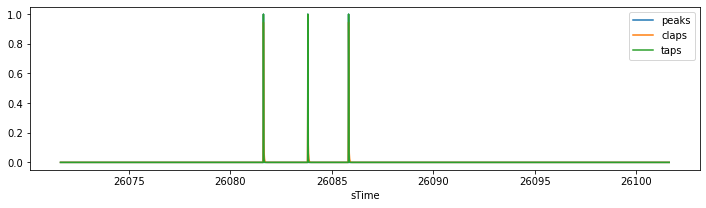

In [45]:
cue = al.cue_template_make(peak_times,int(sf),t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])

CueT['cue2_20240308'] = cue

In [76]:
cue_times = pd.read_csv('./outfiles/cue3_20240305.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
synch_times['cue3_20240305'] = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

28080.852841    28072.5803
28082.719145    28074.4466
28084.478057    28076.2056
Name: SyncTime, dtype: float64

In [17]:
cue_times

,rms,peaks,DateTime,S_AudioTime,SyncTime
26101.943000,0.000704,0,2024-03-08 14:04:31.943000+00:00,26101.9430,26079.3176
26101.945902,0.000905,0,2024-03-08 14:04:31.945902494+00:00,26101.9459,26079.3205
26101.948805,0.001083,0,2024-03-08 14:04:31.948804989+00:00,26101.9488,26079.3234
26101.951707,0.001294,0,2024-03-08 14:04:31.951707483+00:00,26101.9517,26079.3263
26101.954610,0.001304,0,2024-03-08 14:04:31.954609977+00:00,26101.9546,26079.3292
...,...,...,...,...,...
26109.930664,0.000522,0,2024-03-08 14:04:39.930664399+00:00,26109.9307,26087.3053
26109.933567,0.000509,0,2024-03-08 14:04:39.933566893+00:00,26109.9336,26087.3082
26109.936469,0.000510,0,2024-03-08 14:04:39.936469388+00:00,26109.9365,26087.3111
26109.939372,0.000382,0,2024-03-08 14:04:39.939371882+00:00,26109.9394,26087.3140


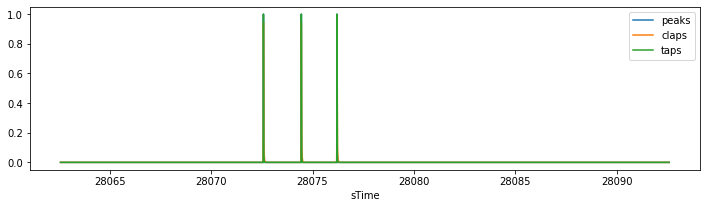

In [78]:
cue = al.cue_template_make(peak_times,int(sf),t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])

CueT['cue3_20240305'] = cue

In [46]:
synch_times

{'cue1_20240308': Timestamp('2024-03-08 06:49:52.625396825'),
 'cue2_20240308': Timestamp('2024-03-08 14:04:34.256287982')}

In [47]:
CueT

{'cue1_20240308':           sTime  peaks           taps  claps
 0    -10.000000      0   0.000000e+00    0.0
 1     -9.996094      0   0.000000e+00    0.0
 2     -9.992188      0   0.000000e+00    0.0
 3     -9.988281      0   0.000000e+00    0.0
 4     -9.984375      0   0.000000e+00    0.0
 ...         ...    ...            ...    ...
 7675  19.980469      0  9.881313e-324    0.0
 7676  19.984375      0  9.881313e-324    0.0
 7677  19.988281      0  9.881313e-324    0.0
 7678  19.992188      0   0.000000e+00    0.0
 7679  19.996094      0   0.000000e+00    0.0
 
 [7680 rows x 4 columns],
 'cue2_20240308':              sTime  peaks           taps  claps
 0     26071.630900      0   0.000000e+00    0.0
 1     26071.634806      0   0.000000e+00    0.0
 2     26071.638713      0   0.000000e+00    0.0
 3     26071.642619      0   0.000000e+00    0.0
 4     26071.646525      0   0.000000e+00    0.0
 ...            ...    ...            ...    ...
 7675  26101.611369      0  9.881313e-324  

## Load example of ACC data

In [81]:
# note special complications: VN104 was not returned on march 04, recorded through to late on march 05
# LS404 was also late on March 05. These need to be synched with Synch 3. 

data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='VN101'
df_datafiles.loc[pid,:]

In [20]:
data_dir='/Volumes/Seagatehub/BiC2024/20240308/Equivital/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='PC710'
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             5022204
Date                                                            240308
Session                                                              0
FileName                               DATA-PC710-5022204-24030800.CSV
FileType                                                           csv
FileSize                                                        151136
RecStart                                     2024-03-08 06:38:45+00:00
RecEnd                                       2024-03-08 14:07:00+00:00
Duration                                                       26895.0
BatteryStart                                                      4100
BatteryEnd                                                        3941
BatteryChange(mV)                                                 -159
FullLoc              /Volumes/Seagatehub/BiC2024/20240308/Equivital...
DATAlo

In [21]:
df_datafiles

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
AU808,DATA,5022031,240308,0,DATA-AU808-5022031-24030800.CSV,csv,157362,2024-03-08 06:29:53+00:00,2024-03-08 14:25:23+00:00,28530.0,...,[AU808],5022031,AU808,53,0,100,1,1,Stationary,Side
AU807,DATA,5022058,240308,0,DATA-AU807-5022058-24030800.CSV,csv,157379,2024-03-08 06:29:54+00:00,2024-03-08 14:25:54+00:00,28560.0,...,[AU807],5022058,AU807,53,0,100,1,1,Stationary,Side
AU806,DATA,5022155,240308,0,DATA-AU806-5022155-24030800.CSV,csv,157385,2024-03-08 06:29:57+00:00,2024-03-08 14:25:42+00:00,28545.0,...,[AU806],5022155,AU806,53,0,100,1,1,Stationary,Side
AU805,DATA,5022002,240308,0,DATA-AU805-5022002-24030800.CSV,csv,157454,2024-03-08 06:29:58+00:00,2024-03-08 14:25:13+00:00,28515.0,...,[AU805],5022002,AU805,53,0,100,1,1,Stationary,Side
AU804,DATA,5022184,240308,0,DATA-AU804-5022184-24030800.CSV,csv,157573,2024-03-08 06:30:00+00:00,2024-03-08 14:26:00+00:00,28560.0,...,[AU804],5022184,AU804,53,2,100,1,1,Stationary,Side
AU801,DATA,5022179,240308,0,DATA-AU801-5022179-24030800.CSV,csv,157421,2024-03-08 06:30:02+00:00,2024-03-08 14:25:47+00:00,28545.0,...,[AU801],5022179,AU801,53,0,100,1,1,Stationary,Side
AU809,DATA,5022060,240308,0,DATA-AU809-5022060-24030800.CSV,csv,156960,2024-03-08 06:30:39+00:00,2024-03-08 14:25:54+00:00,28515.0,...,[AU809],5022060,AU809,53,2,100,1,1,Stationary,Side
AU810,DATA,5022098,240308,0,DATA-AU810-5022098-24030800.CSV,csv,156673,2024-03-08 06:30:41+00:00,2024-03-08 14:24:56+00:00,28455.0,...,[AU810],5022098,AU810,53,0,100,1,1,Stationary,Side
AU811,DATA,5022173,240308,0,DATA-AU811-5022173-24030800.CSV,csv,156805,2024-03-08 06:30:42+00:00,2024-03-08 14:25:12+00:00,28470.0,...,[AU811],5022173,AU811,53,0,100,1,1,Stationary,Side


In [67]:
weird_pid = ['VN211'] # VN101? 

In [48]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
# V = pd.read_csv('./testing/FASTACC-BR604-5022198-24030700.CSV',skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
ACC.loc[:5,:]

,dev_dTime,signal
0,2024-03-08 06:38:17.007,0.0
1,2024-03-08 06:38:17.011,0.0
2,2024-03-08 06:38:17.015,0.0
3,2024-03-08 06:38:17.019,0.0
4,2024-03-08 06:38:17.023,0.0
5,2024-03-08 06:38:17.027,0.0


In [49]:
c = 'cue1_20240308'

In [50]:
synch_times[c]

Timestamp('2024-03-08 06:49:52.625396825')

15360


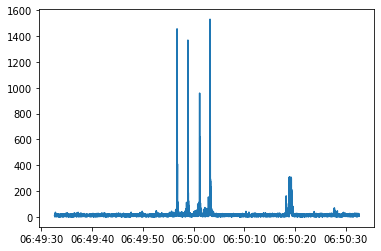

In [51]:
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(40,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
print(len(ACC_ex))
plt.plot(ACC_ex['dev_dTime'],ACC_ex['signal'])

In [52]:
# it seems the clocks on the equivitals are nearly 30 s of from the time selected in the cue findings. 
# We can fix this in TimeAlign/Shake_Audio_Cue.ipynb

c = 'cue1_20240308'
cue = CueT[c].copy()
prelim_synch_time = (synch_times[c]+pd.to_timedelta(0,unit='s')).tz_localize(None)
print(prelim_synch_time)
cue

2024-03-08 06:49:52.625396825


,sTime,peaks,taps,claps
0,-10.000000,0,0.000000e+00,0.0
1,-9.996094,0,0.000000e+00,0.0
2,-9.992188,0,0.000000e+00,0.0
3,-9.988281,0,0.000000e+00,0.0
4,-9.984375,0,0.000000e+00,0.0
...,...,...,...,...
7675,19.980469,0,9.881313e-324,0.0
7676,19.984375,0,9.881313e-324,0.0
7677,19.988281,0,9.881313e-324,0.0
7678,19.992188,0,0.000000e+00,0.0


In [53]:
sampleshift_s = cue['sTime'].diff().median()
sf = np.round(1/sampleshift_s)
t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
c_type = 'taps'
xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
          pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

max_offs = 5
X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
sig_v = X['signal']
f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
new_sig = f(sig_sTime)
signal = pd.DataFrame()
signal.loc[:,'signal'] = new_sig
signal.loc[signal['signal'].isna(),'signal'] = 0
# scale signals a little 
M = signal['signal'].quantile(0.998)
signal.loc[:,'signal']  = signal['signal']/M
signal.loc[signal['signal']>1,'signal'] = 1
signal.loc[signal['signal']<0,'signal'] = 0
signal.loc[:,'sTime'] = sig_sTime
signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
length = np.min([len(signal),len(cue)]) # they should match, but just in case
# plt.plot(cue['dTime'],cue['taps'])

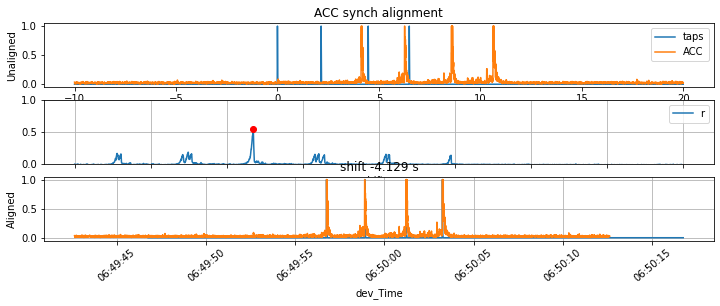

2024-03-08 06:49:56.754303075


In [54]:
xcorred = pd.DataFrame()
max_offs = 10
xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
max_r = xcorred['r'].max()
cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

fig, axes = plt.subplots(3,1,figsize=(12,4))
ax =axes[0]
cue.plot(x='sTime',y=c_type,ax=ax)
signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
ax.set_title('ACC synch alignment')
ax.set_ylabel('Unaligned')
ax.legend()

ax = axes[1]
xcorred.plot(x='shift_s',y='r',ax=ax)
ax.plot(max_shift,max_r,'ro')
ax.set_ylim([0,1])
ax.grid(True)
ax.set_xticklabels('')

ax = axes[2]
ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
ax.xaxis.set_tick_params(rotation=40)

ax.grid(True)
ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
ax.set_ylabel('Aligned')
ax.set_xlabel('dev_Time')
plt.show()

cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
C_results = {'best': cue_time,'CCC':xcorred,'cue':cue,'signal':signal}
print(cue_time)

In [55]:
synch_times[c]

Timestamp('2024-03-08 06:49:52.625396825')

In [56]:
ACC.iloc[-5:,:]

,dev_dTime,signal
6896464,2024-03-08 14:07:16.331,13.892444
6896465,2024-03-08 14:07:16.335,9.797959
6896466,2024-03-08 14:07:16.339,16.552945
6896467,2024-03-08 14:07:16.343,15.524175
6896468,2024-03-08 14:07:16.347,14.456832


In [57]:
dt_0 

Timestamp('2024-03-08 06:49:32.625396825')

In [58]:
CueT[c]

,sTime,peaks,taps,claps
0,-10.000000,0,0.000000e+00,0.0
1,-9.996094,0,0.000000e+00,0.0
2,-9.992188,0,0.000000e+00,0.0
3,-9.988281,0,0.000000e+00,0.0
4,-9.984375,0,0.000000e+00,0.0
...,...,...,...,...
7675,19.980469,0,9.881313e-324,0.0
7676,19.984375,0,9.881313e-324,0.0
7677,19.988281,0,9.881313e-324,0.0
7678,19.992188,0,0.000000e+00,0.0


In [59]:
synch_times['cue2_20240308']

Timestamp('2024-03-08 14:04:34.256287982')

In [60]:
ACC_ex

,dev_dTime,signal
172956,2024-03-08 06:49:32.628,13.304135
172957,2024-03-08 06:49:32.632,15.000000
172958,2024-03-08 06:49:32.636,5.656854
172959,2024-03-08 06:49:32.640,19.824228
172960,2024-03-08 06:49:32.644,14.177447
...,...,...
188311,2024-03-08 06:50:32.609,14.730920
188312,2024-03-08 06:50:32.613,5.656854
188313,2024-03-08 06:50:32.617,8.062258
188314,2024-03-08 06:50:32.620,4.000000


In [61]:
c = 'cue2_20240308'
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(40,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
ACC_ex

,dev_dTime,signal
6849853,2024-03-08 14:04:14.257,20.000000
6849854,2024-03-08 14:04:14.261,46.840154
6849855,2024-03-08 14:04:14.265,25.632011
6849856,2024-03-08 14:04:14.269,45.099889
6849857,2024-03-08 14:04:14.273,90.708324
...,...,...
6865208,2024-03-08 14:05:14.238,36.345564
6865209,2024-03-08 14:05:14.242,35.791060
6865210,2024-03-08 14:05:14.245,17.029386
6865211,2024-03-08 14:05:14.249,8.544004


In [62]:
CueT[c]

,sTime,peaks,taps,claps
0,26071.630900,0,0.000000e+00,0.0
1,26071.634806,0,0.000000e+00,0.0
2,26071.638713,0,0.000000e+00,0.0
3,26071.642619,0,0.000000e+00,0.0
4,26071.646525,0,0.000000e+00,0.0
...,...,...,...,...
7675,26101.611369,0,9.881313e-324,0.0
7676,26101.615275,0,9.881313e-324,0.0
7677,26101.619181,0,9.881313e-324,0.0
7678,26101.623088,0,0.000000e+00,0.0


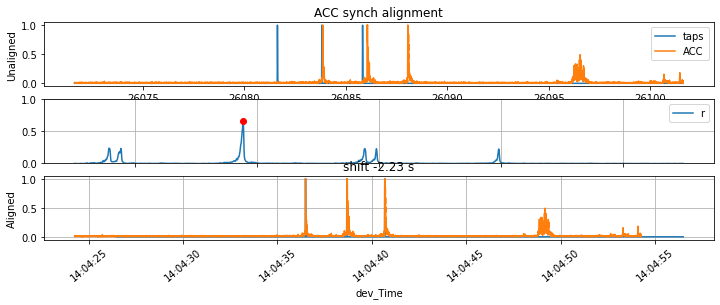

Timestamp('2024-03-08 14:04:36.486765575')

In [63]:
c = 'cue2_20240308'
results = min_align(ACC,CueT[c].copy(),synch_times['cue1_20240308'].tz_localize(None),10)
results['best_dt']

# Running through the sensors

In [64]:
data_dir='/Volumes/Seagatehub/BiC2024/20240308/Equivital/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]


,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
AU808,DATA,5022031,240308,0,DATA-AU808-5022031-24030800.CSV,csv,157362,2024-03-08 06:29:53+00:00,2024-03-08 14:25:23+00:00,28530.0,...,[AU808],5022031,AU808,53,0,100,1,1,Stationary,Side
AU807,DATA,5022058,240308,0,DATA-AU807-5022058-24030800.CSV,csv,157379,2024-03-08 06:29:54+00:00,2024-03-08 14:25:54+00:00,28560.0,...,[AU807],5022058,AU807,53,0,100,1,1,Stationary,Side
AU806,DATA,5022155,240308,0,DATA-AU806-5022155-24030800.CSV,csv,157385,2024-03-08 06:29:57+00:00,2024-03-08 14:25:42+00:00,28545.0,...,[AU806],5022155,AU806,53,0,100,1,1,Stationary,Side
AU805,DATA,5022002,240308,0,DATA-AU805-5022002-24030800.CSV,csv,157454,2024-03-08 06:29:58+00:00,2024-03-08 14:25:13+00:00,28515.0,...,[AU805],5022002,AU805,53,0,100,1,1,Stationary,Side
AU804,DATA,5022184,240308,0,DATA-AU804-5022184-24030800.CSV,csv,157573,2024-03-08 06:30:00+00:00,2024-03-08 14:26:00+00:00,28560.0,...,[AU804],5022184,AU804,53,2,100,1,1,Stationary,Side


['AU808', 25.930415153503418]


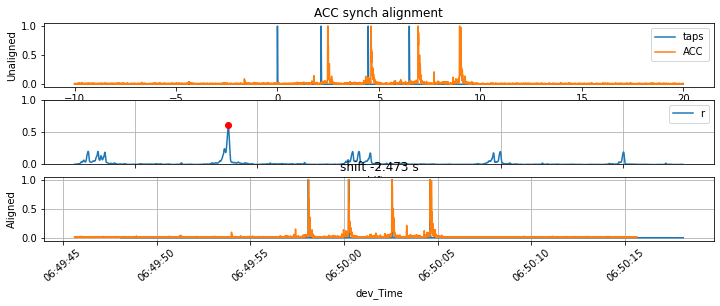

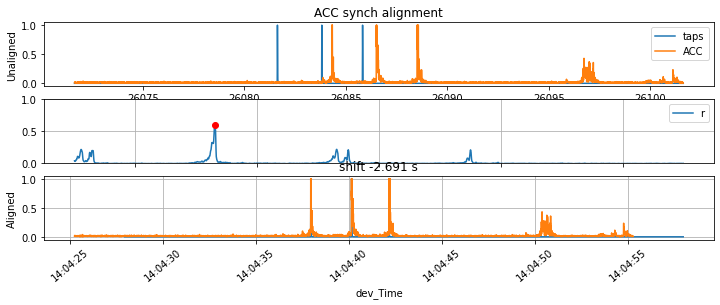

['AU807', 55.179322957992554]


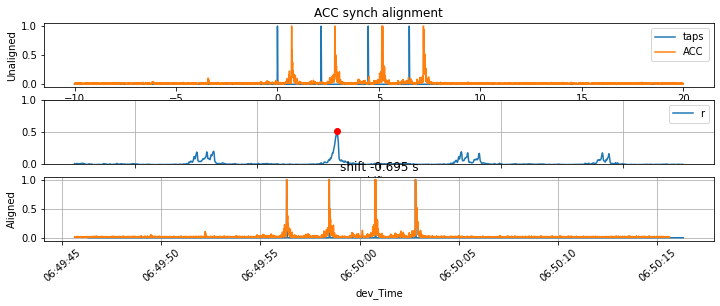

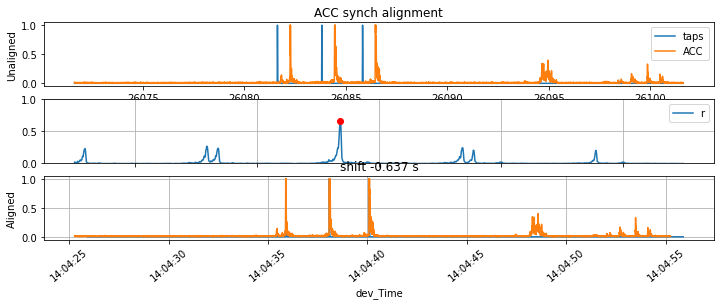

['AU806', 84.34072923660278]


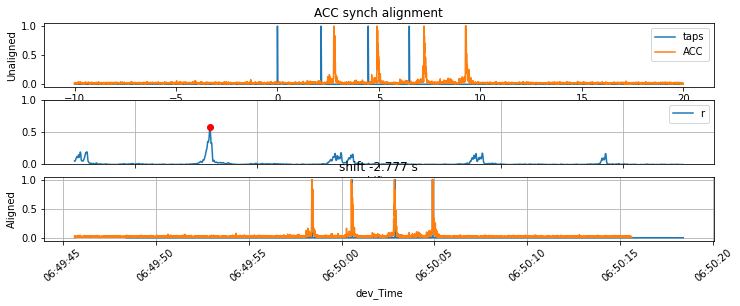

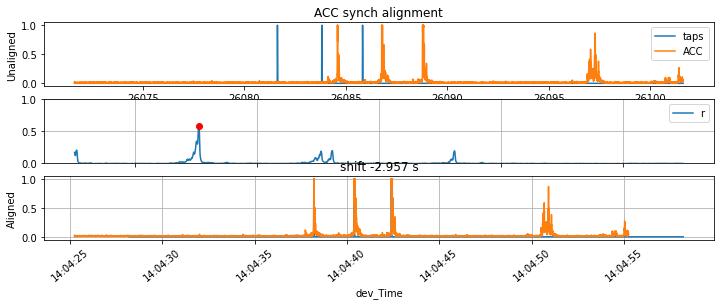

['AU805', 114.35059094429016]


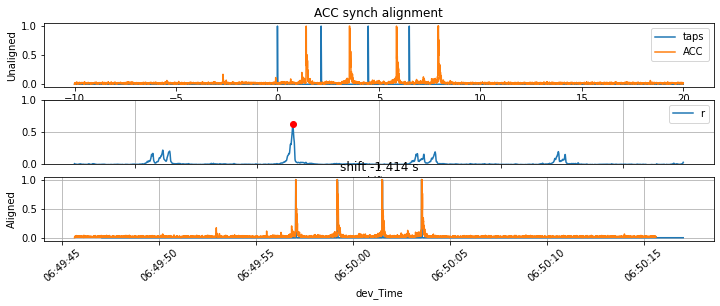

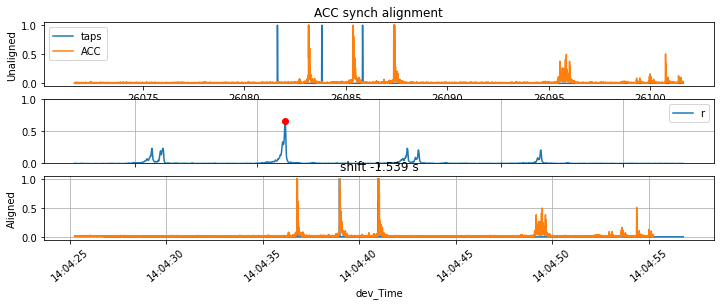

['AU804', 144.71899604797363]


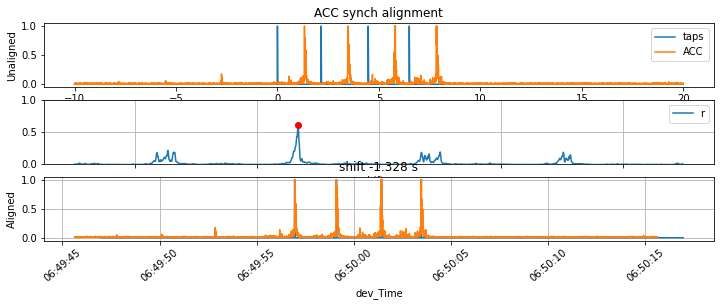

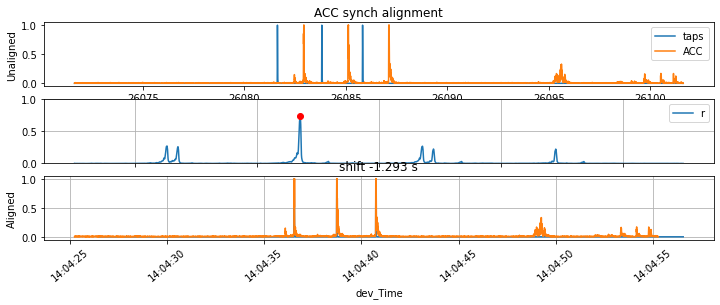

['AU801', 173.80715918540955]


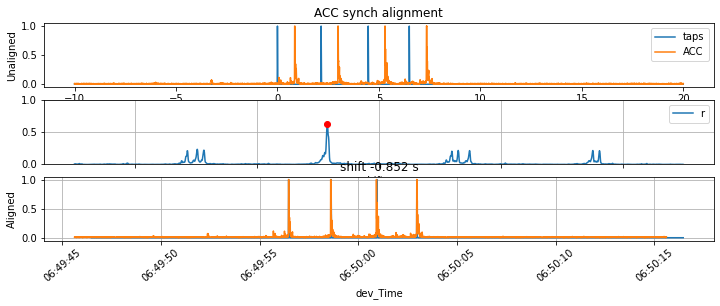

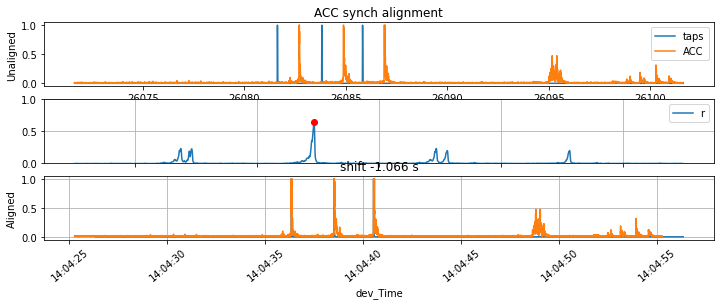

['AU809', 203.68045806884766]


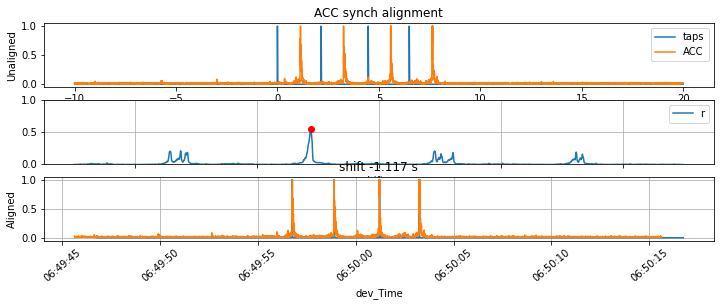

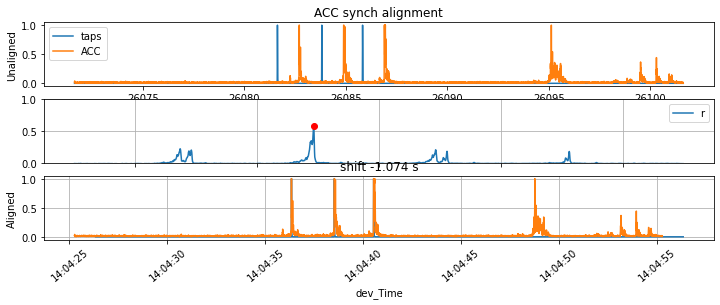

['AU810', 234.1939778327942]


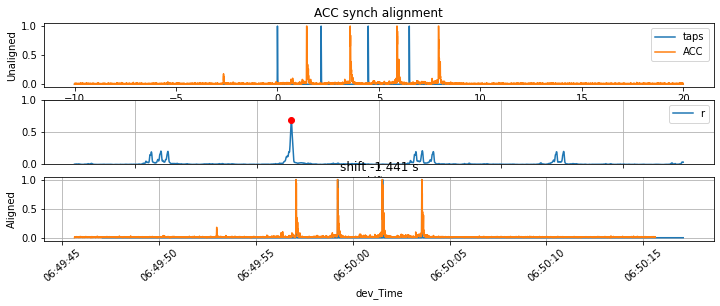

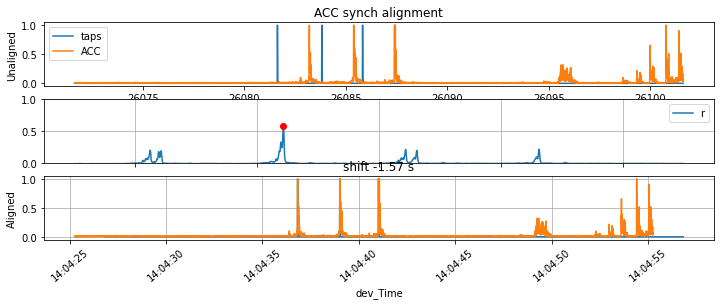

['AU811', 264.335009098053]


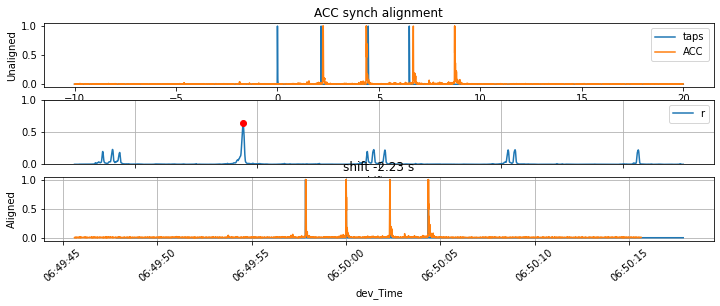

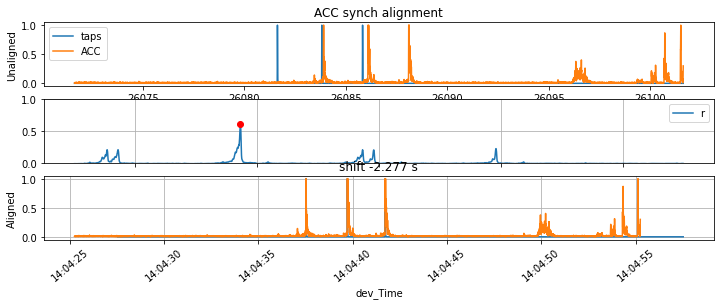

['AU813', 294.9135401248932]


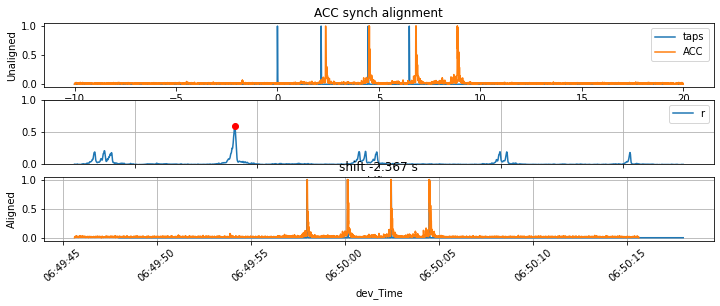

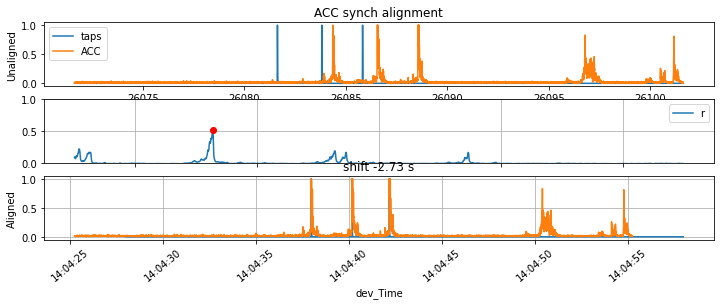

['AU812', 324.65022802352905]


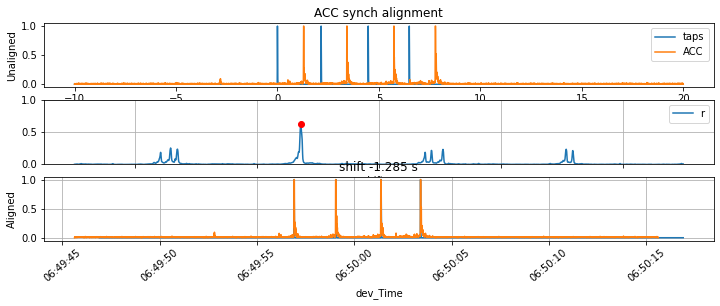

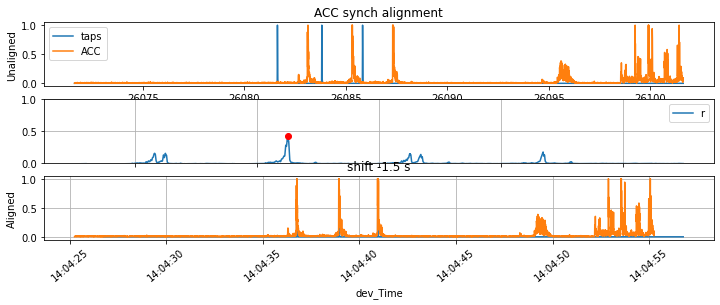

['VN212', 354.34822821617126]


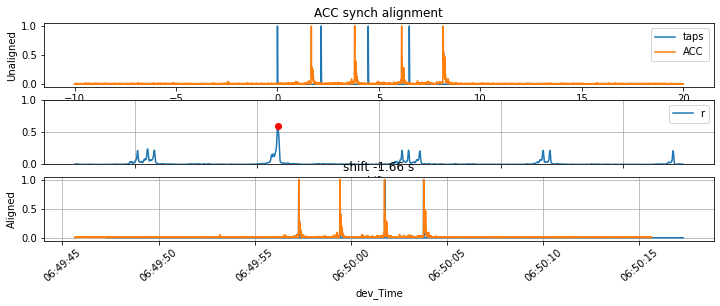

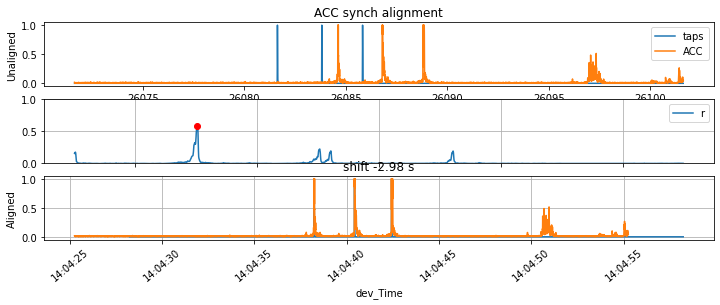

['VA304', 383.5866861343384]


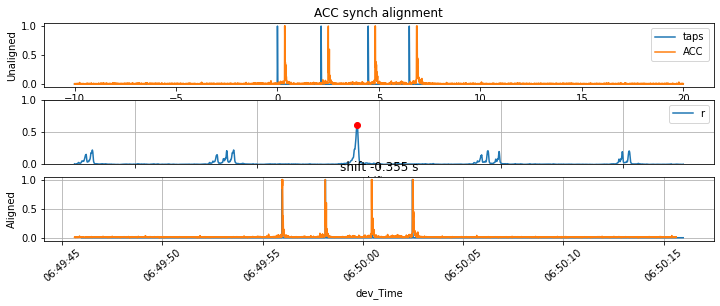

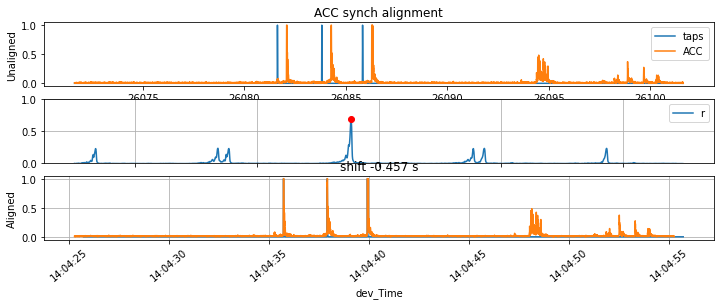

['VN206', 412.3876209259033]


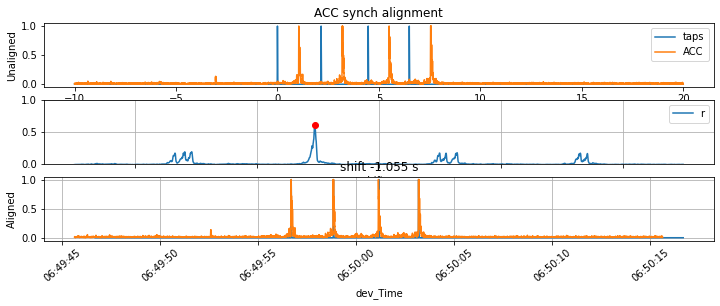

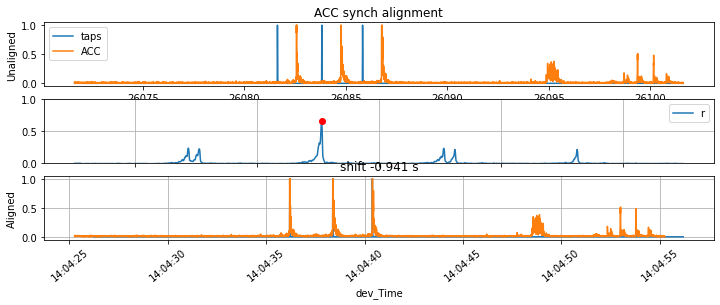

['VN111', 443.06702280044556]


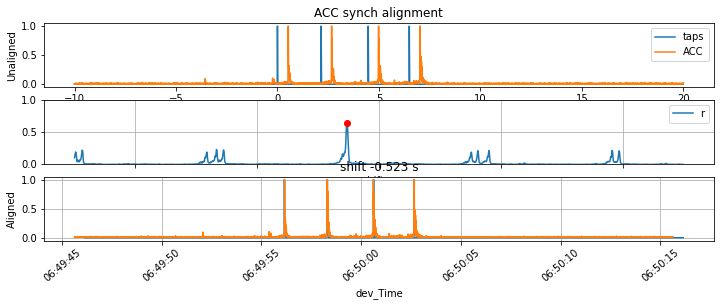

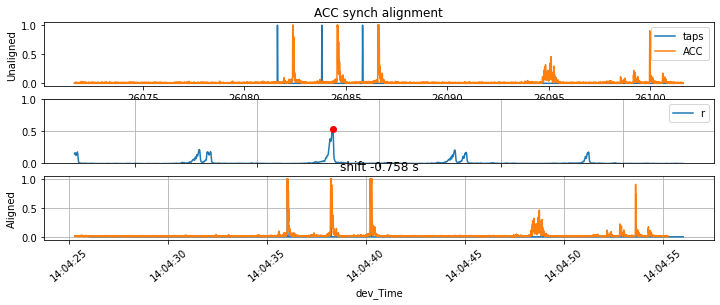

['VN201', 471.51801800727844]


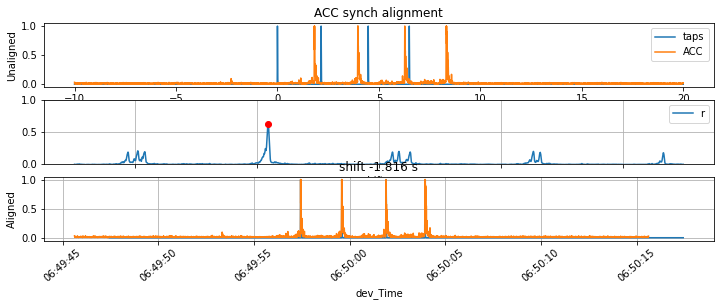

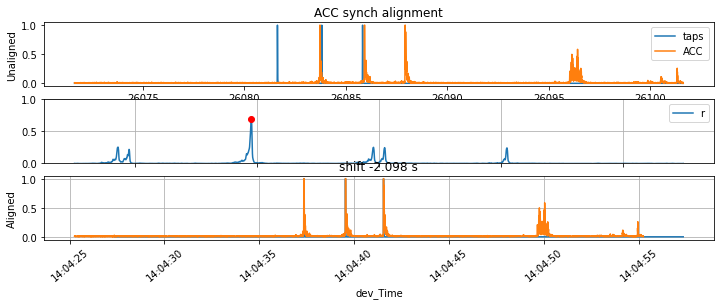

['VA305', 499.9064121246338]


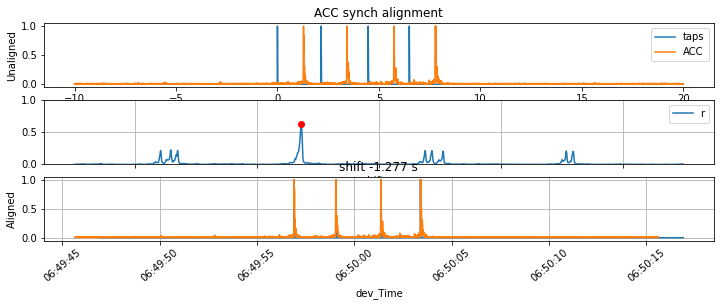

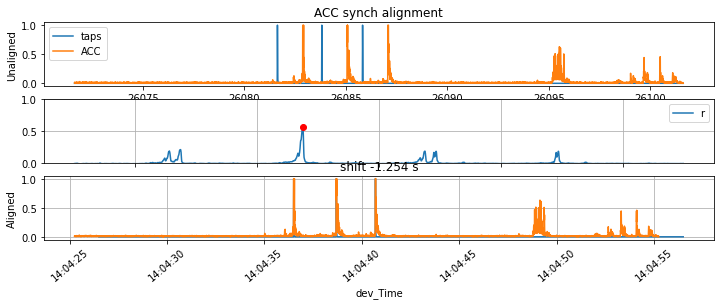

['VA309', 528.5824809074402]


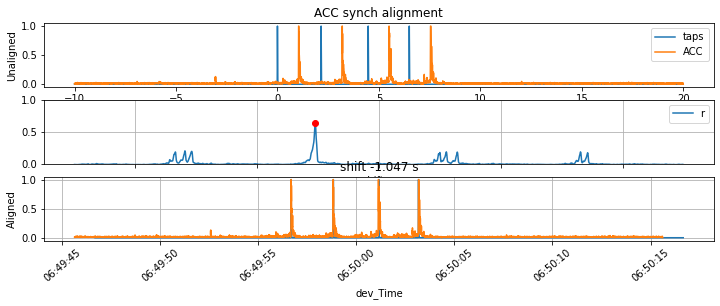

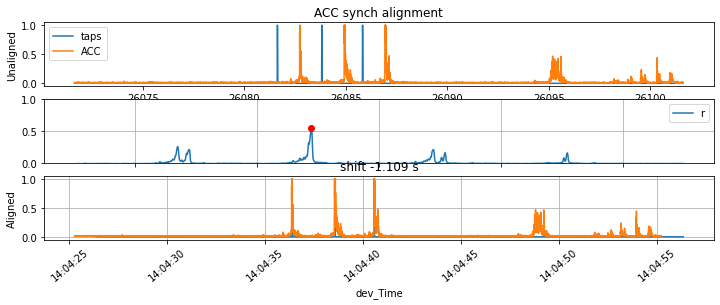

['LS401', 557.1845471858978]


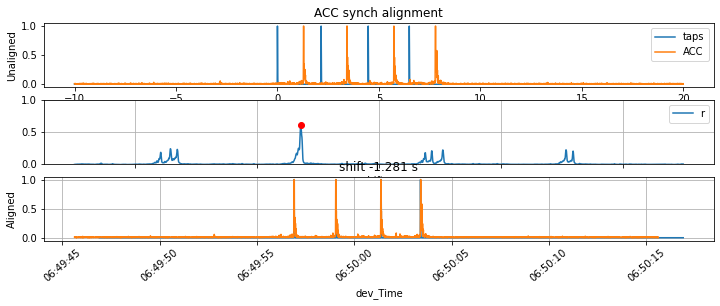

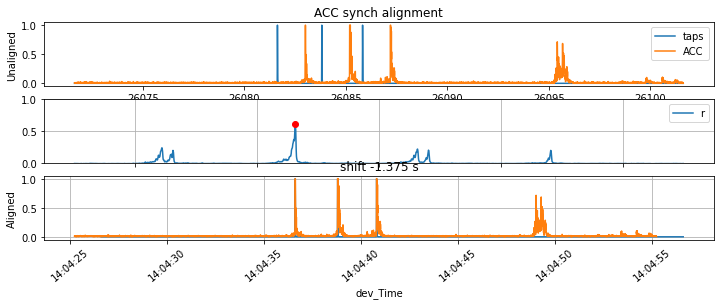

['AU802', 586.544361114502]


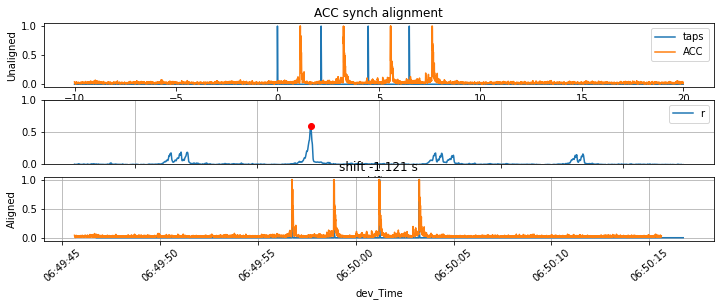

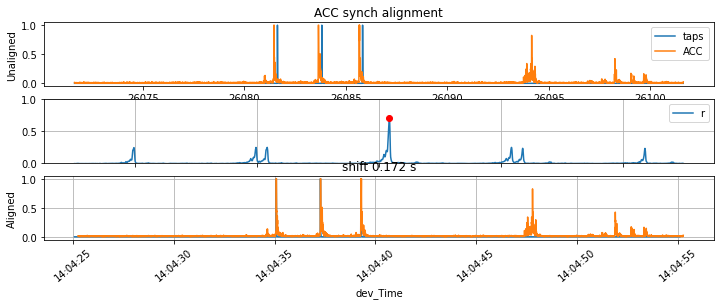

['VN101', 618.5610060691833]


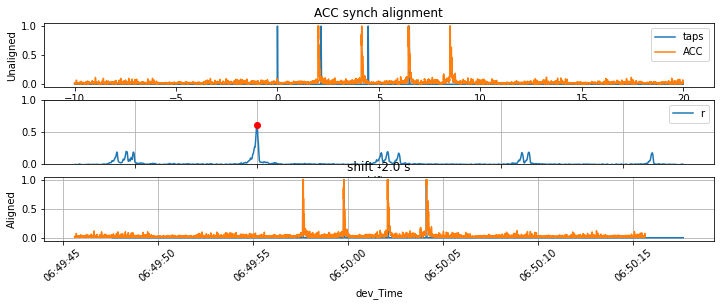

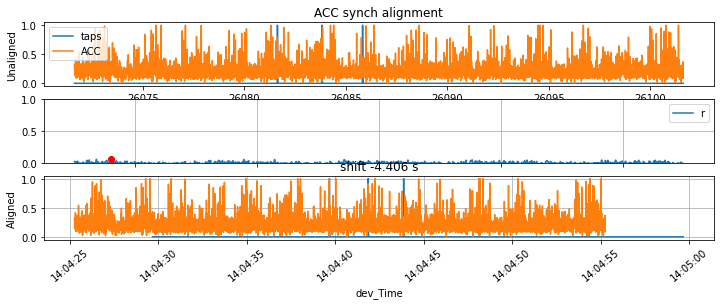

['VN104', 647.9300329685211]


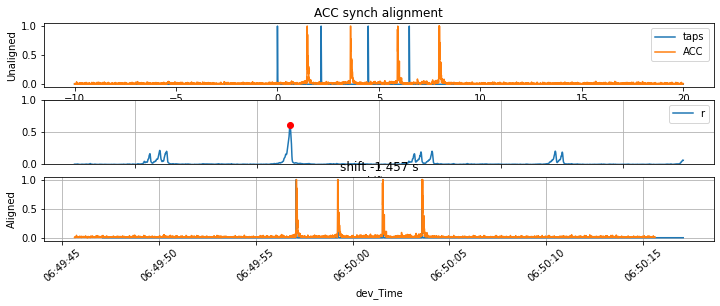

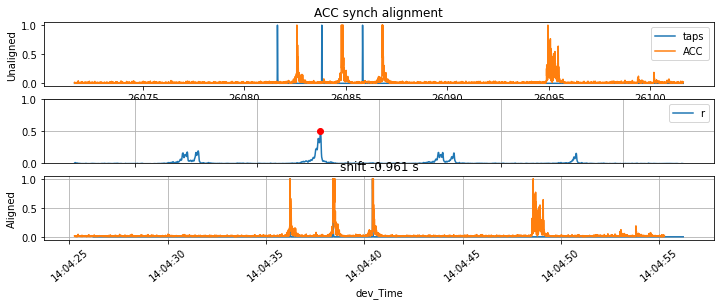

['VN105', 677.4600369930267]


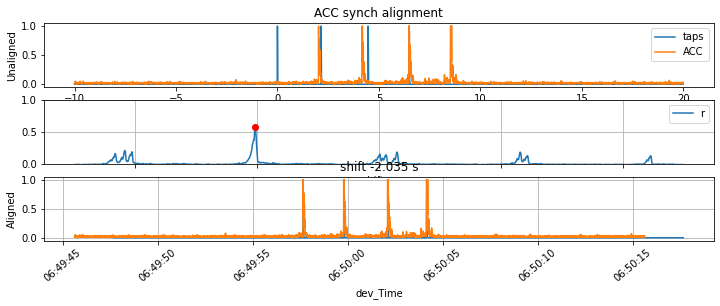

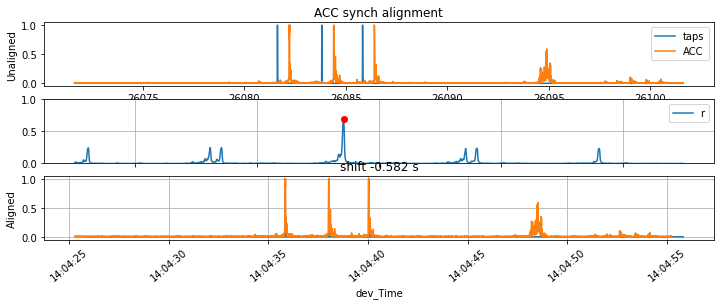

['VN109', 706.5580320358276]


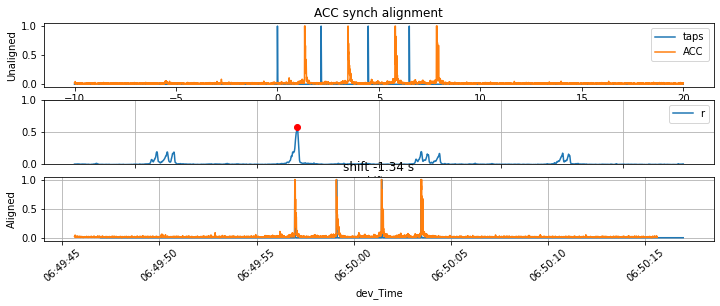

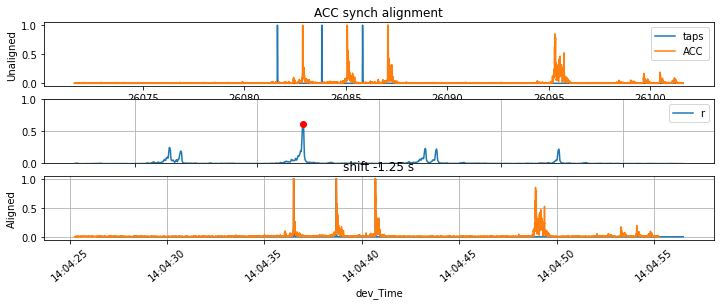

['VN110', 736.7391192913055]


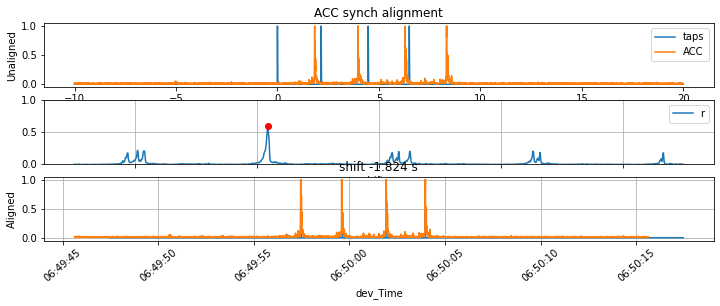

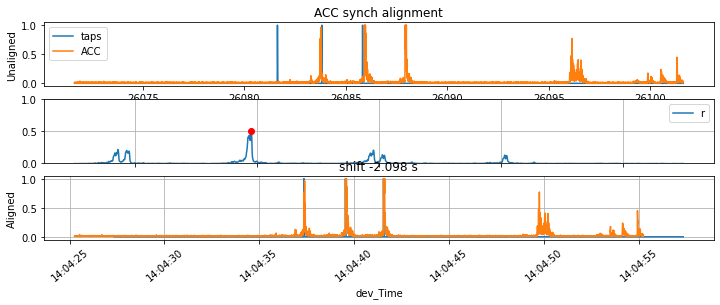

['AU803', 772.8597221374512]


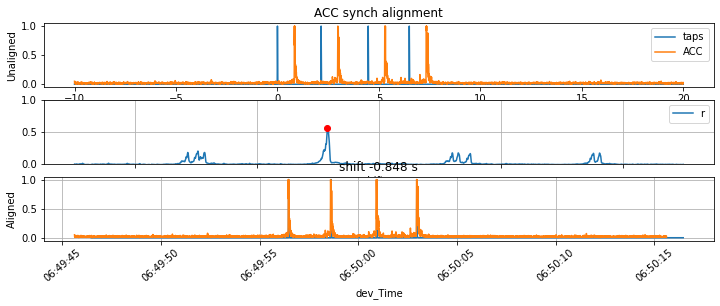

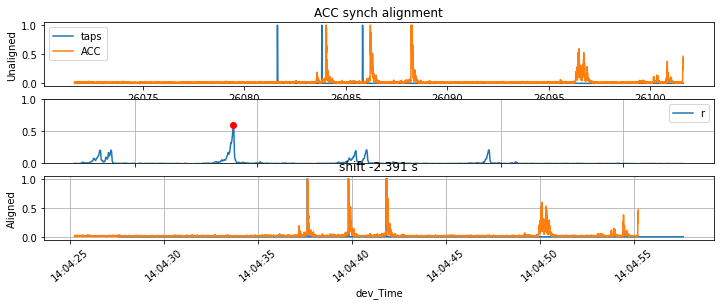

['LS404', 801.7259089946747]


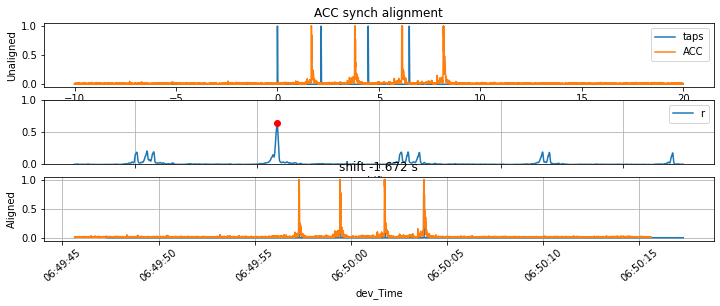

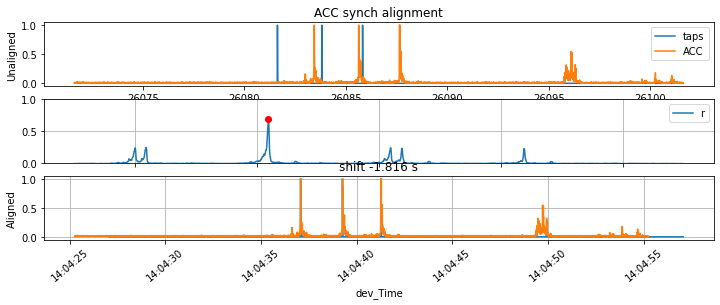

['LS405', 830.9250431060791]


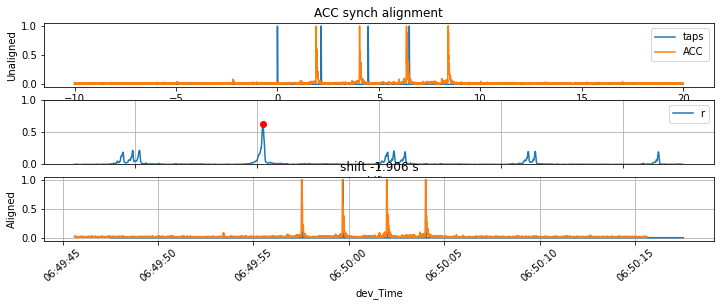

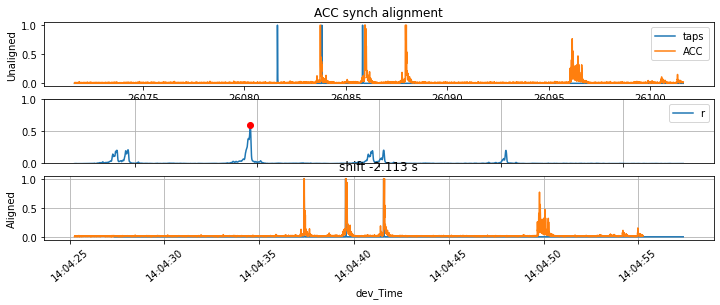

['LS407', 861.6832871437073]


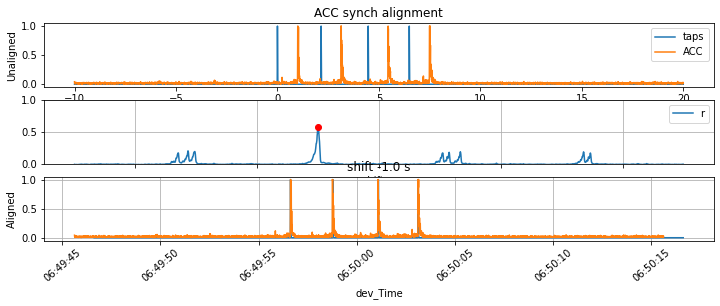

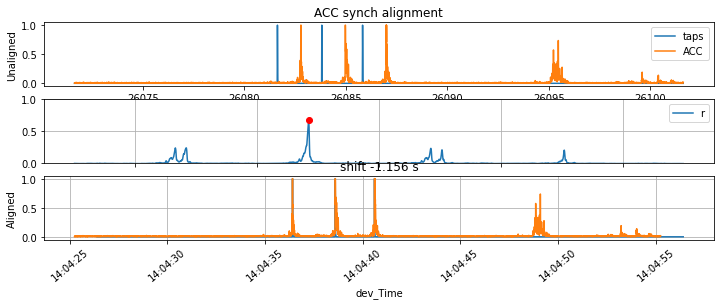

['LS410', 892.0020942687988]


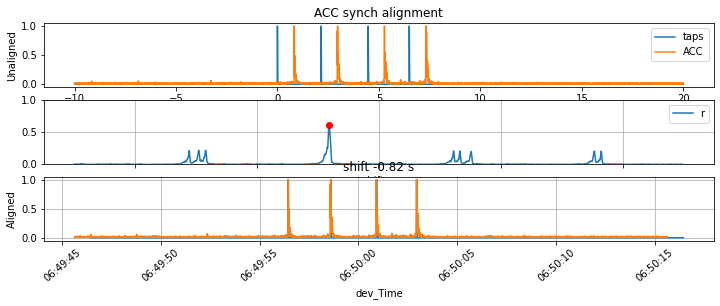

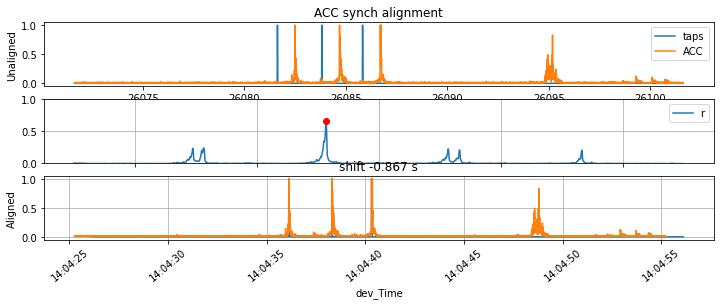

['LS409', 920.2075080871582]


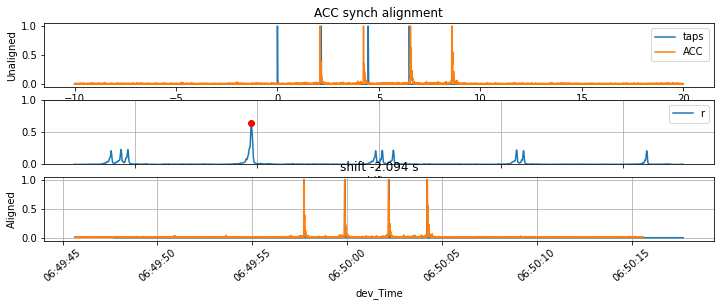

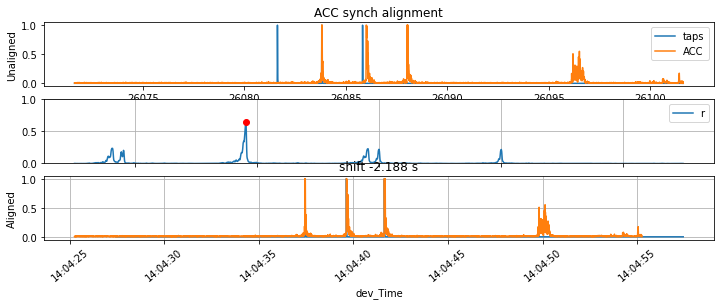

['WW504', 949.5751760005951]


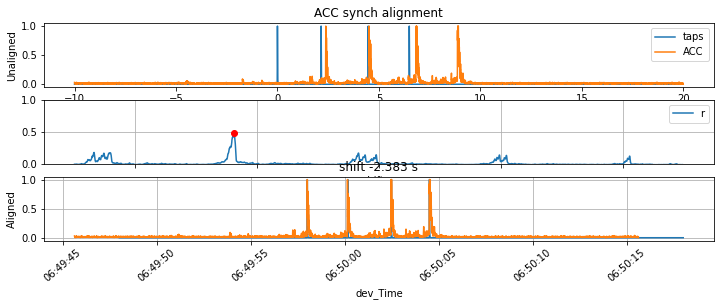

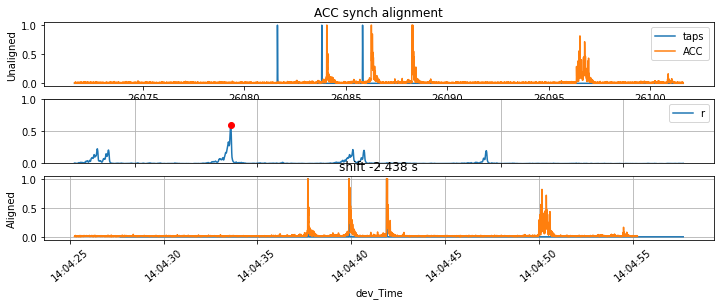

['WW506', 979.0881791114807]


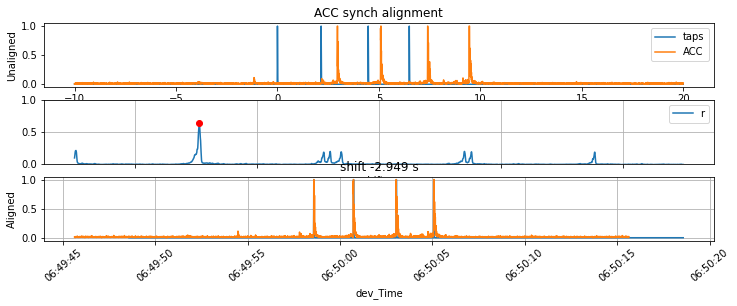

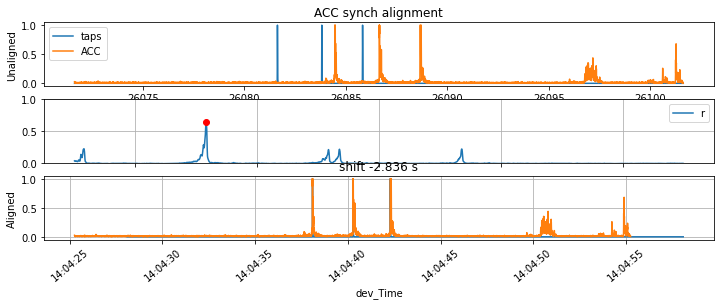

['WW507', 1007.1878411769867]


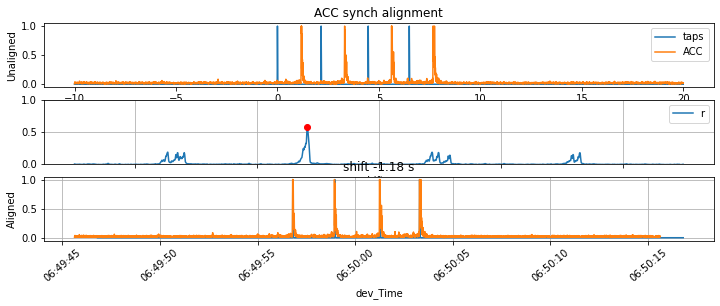

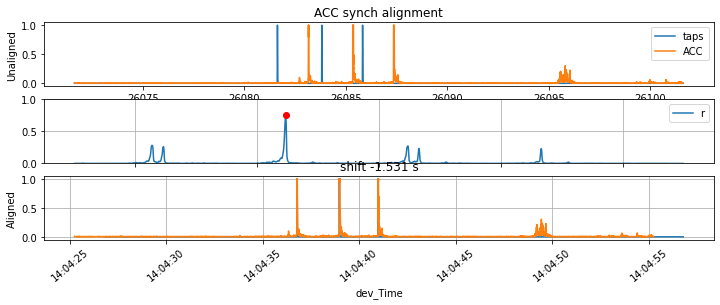

['WW508', 1034.4125261306763]


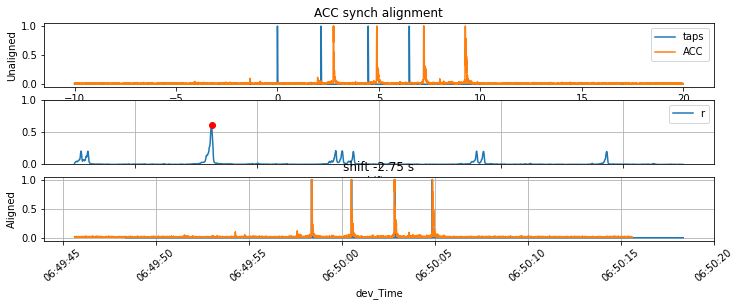

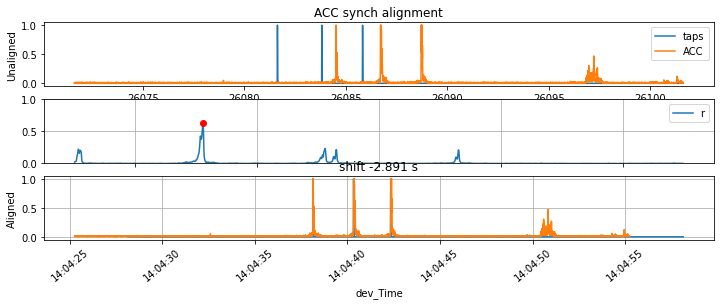

['BR604', 1061.6095390319824]


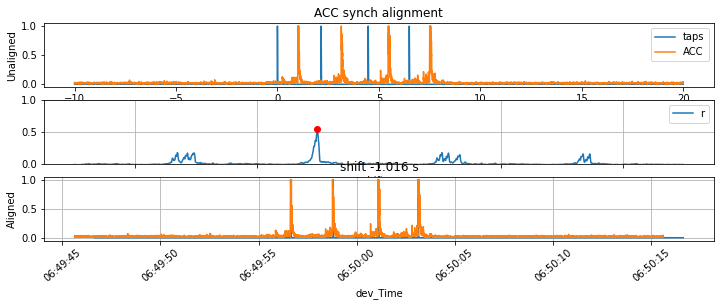

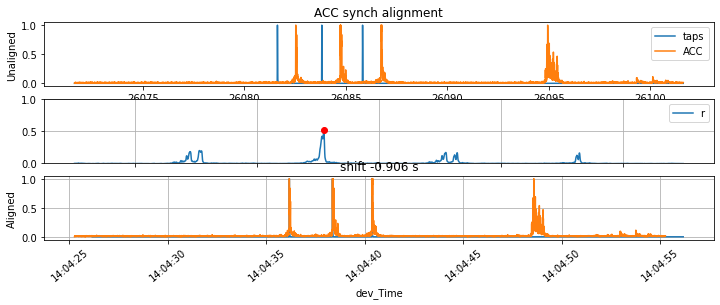

['BR605', 1089.6440000534058]


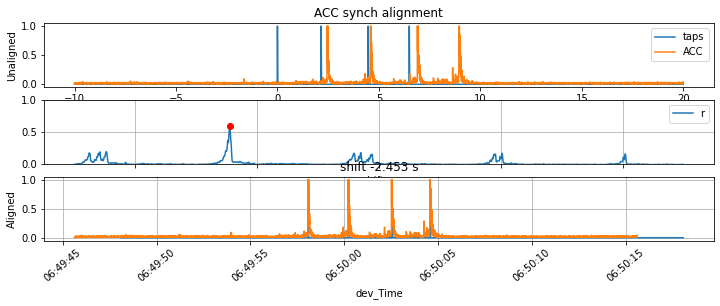

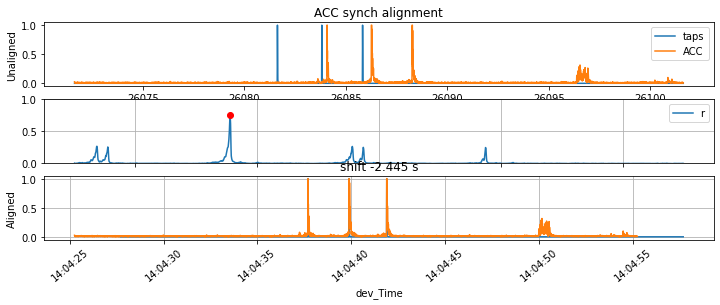

['BR609', 1117.4224269390106]


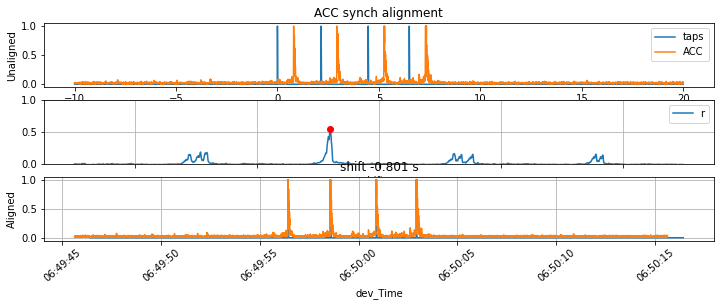

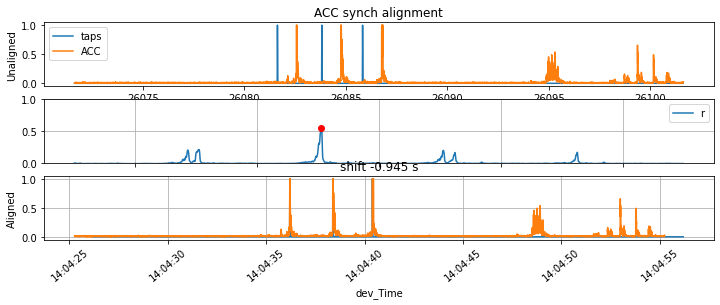

['BR606', 1145.3880290985107]


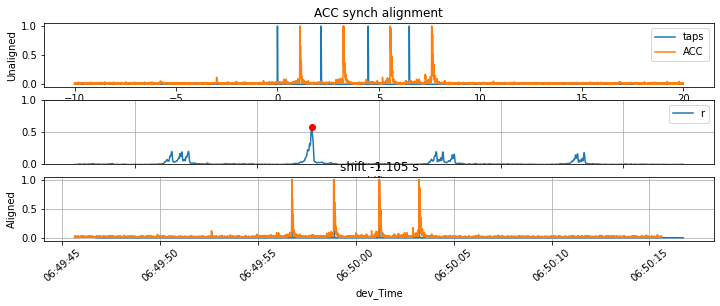

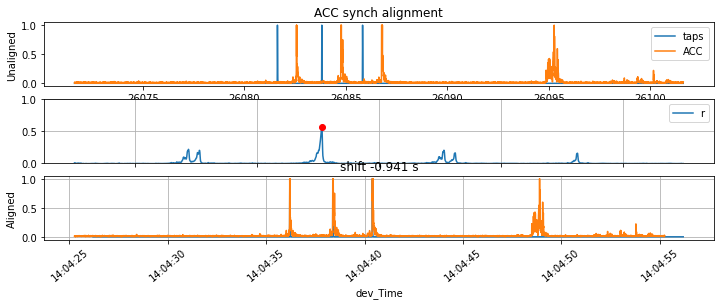

['BR608', 1174.1740291118622]


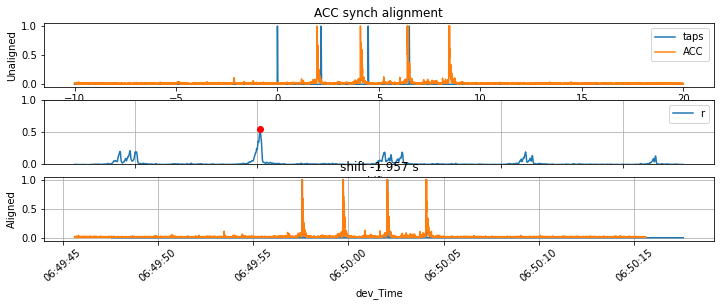

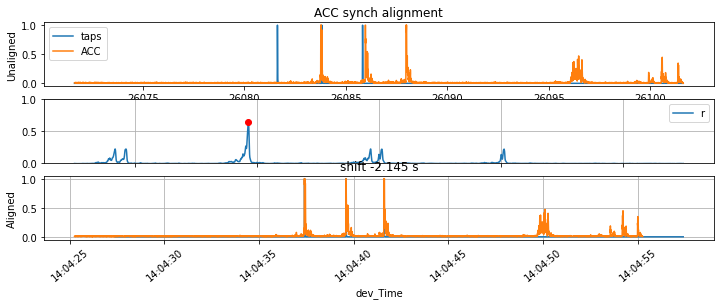

['PC702', 1203.576169013977]


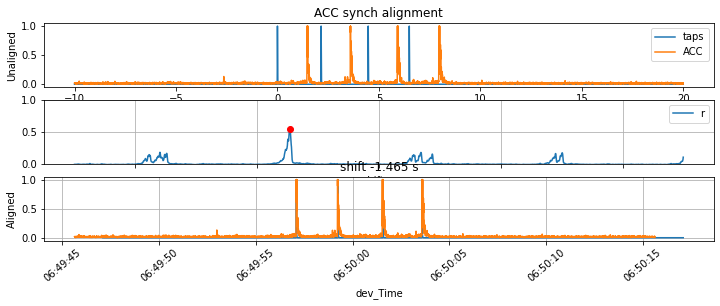

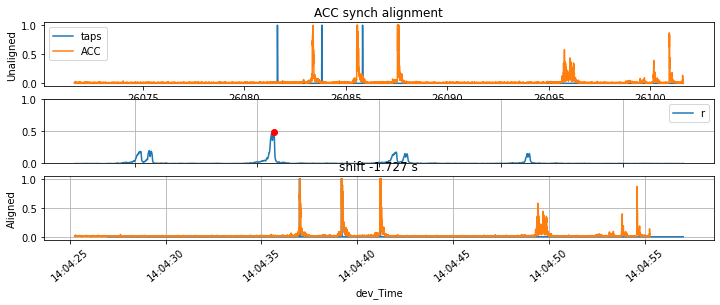

['PC709', 1232.7811222076416]


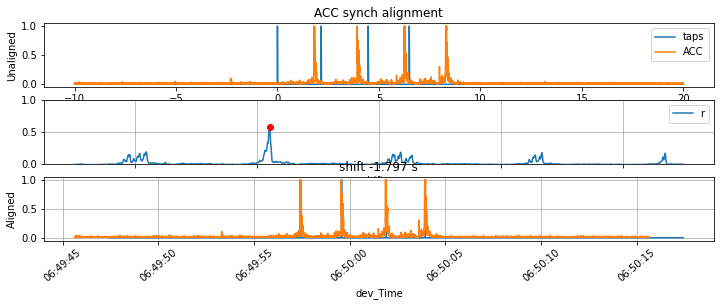

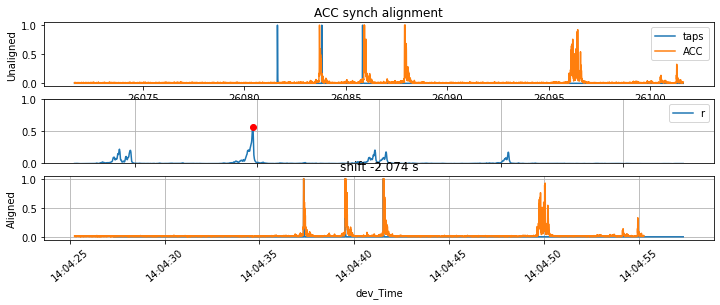

['PC710', 1261.2395980358124]


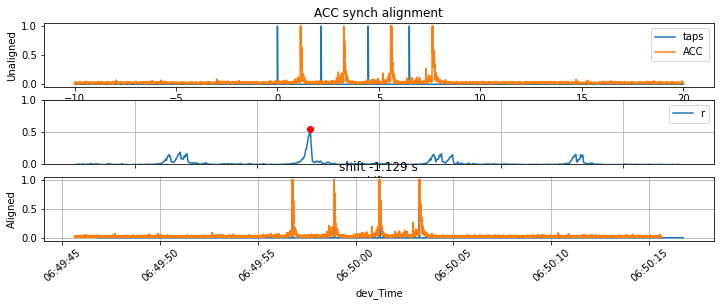

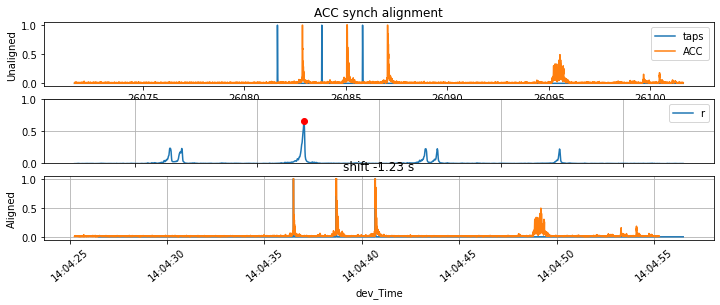

1263.7046310901642


,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r
DevName,,,,,,
AU808,2024-03-08 06:49:58.098053075,-2.472656,0.607847,2024-03-08 14:04:37.947703075,-0.691406,0.58871
AU807,2024-03-08 06:49:56.320709325,-0.695312,0.517968,2024-03-08 14:04:35.893015575,1.363281,0.661651
AU806,2024-03-08 06:49:58.402740575,-2.777344,0.583299,2024-03-08 14:04:38.213328075,-0.957031,0.57312
AU805,2024-03-08 06:49:57.039459325,-1.414062,0.626559,2024-03-08 14:04:36.795359325,0.460938,0.651299
AU804,2024-03-08 06:49:56.953521825,-1.328125,0.608979,2024-03-08 14:04:36.549265575,0.707031,0.73345
AU801,2024-03-08 06:49:56.476959325,-0.851562,0.62971,2024-03-08 14:04:36.322703075,0.933594,0.640246
AU809,2024-03-08 06:49:56.742584325,-1.117188,0.548963,2024-03-08 14:04:36.330515575,0.925781,0.578137
AU810,2024-03-08 06:49:57.066803075,-1.441406,0.684348,2024-03-08 14:04:36.826609325,0.429688,0.571643
AU811,2024-03-08 06:49:57.855865575,-2.230469,0.641368,2024-03-08 14:04:37.533640575,-0.277344,0.607188


In [74]:
df_shifts = pd.DataFrame(index = df_datafiles.index,columns = ['Cue1_devdTime','Cue1_s','Cue1_r','Cue2_devdTime','Cue2_s','Cue2_r'])
tic = time.time()
t_center = 3
t_drift = 2

for pid,row in df_datafiles.iterrows():
    if pid not in weird_pid: # 'VN101'
        V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
        ACC = pd.DataFrame()
        ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
        ACC = remove_tz_from_dataframe(ACC)
        print([pid,time.time()-tic])

        dt_0 = synch_times['cue1_20240308']-pd.to_timedelta(25,unit='s')
        dt_1 = synch_times['cue1_20240308']+pd.to_timedelta(25,unit='s')
        ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
        maxlag_s = 5
        results = min_align(ACC_ex,CueT['cue1_20240308'].copy(),(synch_times['cue1_20240308']+pd.to_timedelta(t_center,unit='s')).tz_localize(None),maxlag_s)
        df_shifts.loc[pid,'Cue1_devdTime'] = results['best_dt']
        df_shifts.loc[pid,'Cue1_s'] = results['best_s']
        df_shifts.loc[pid,'Cue1_r'] = results['best_r']

        dt_0 = synch_times['cue2_20240308']-pd.to_timedelta(25,unit='s')
        dt_1 = synch_times['cue2_20240308']+pd.to_timedelta(25,unit='s')
        ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
        maxlag_s = 10
        results = min_align(ACC_ex,CueT['cue2_20240308'].copy(),(synch_times['cue1_20240308']+pd.to_timedelta(t_center-t_drift,unit='s')).tz_localize(None),maxlag_s)
        df_shifts.loc[pid,'Cue2_devdTime'] = results['best_dt']
        df_shifts.loc[pid,'Cue2_s'] = results['best_s']+t_drift
        df_shifts.loc[pid,'Cue2_r'] = results['best_r']
    
print(time.time()-tic)
df_shifts

In [75]:
[df_shifts['Cue1_s'].mean(),df_shifts['Cue2_s'].mean()]

[-1.537154796511628, 0.32385537790697677]

In [76]:
df_shifts['dur_dt']=pd.to_datetime(df_shifts['Cue2_devdTime'])-pd.to_datetime(df_shifts['Cue1_devdTime'])
df_shifts['dur_s']=df_shifts['dur_dt'].dt.total_seconds() #pd.to_datetime(cue_times['DateTime'],format='ISO8601')

In [77]:
(synch_times['cue2_20240308']-synch_times['cue1_20240308']).total_seconds()

26081.630891

In [78]:
df_shifts['devID'] = df_datafiles['ID']

In [84]:
df_shifts.columns

Index(['Cue1_devdTime', 'Cue1_s', 'Cue1_r', 'Cue2_devdTime', 'Cue2_s',
       'Cue2_r', 'dur_dt', 'dur_s', 'devID', 'drift_s', 'drift_rate_sphr'],
      dtype='object')

In [87]:
df_shifts.loc['VN101',['Cue2_devdTime', 'Cue2_s','Cue2_r', 'dur_dt', 'dur_s','drift_s', 'drift_rate_sphr']]=df_shifts.loc['VN211',['Cue2_devdTime', 'Cue2_s','Cue2_r', 'dur_dt', 'dur_s','drift_s', 'drift_rate_sphr']]

In [86]:
df_shifts.loc['VN211',['Cue2_devdTime', 'Cue2_s','Cue2_r', 'dur_dt', 'dur_s','drift_s', 'drift_rate_sphr']]

Cue2_devdTime      NaN
Cue2_s             NaN
Cue2_r             NaN
dur_dt             NaT
dur_s              NaN
drift_s            NaN
drift_rate_sphr    NaN
Name: VN211, dtype: object

In [88]:
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr
DevName,,,,,,,,,,,
AU808,2024-03-08 06:49:58.098053075,-2.472656,0.607847,2024-03-08 14:04:37.947703075,-0.691406,0.58871,0 days 07:14:39.849650,26079.849650,5022031,-1.781241,-0.245861
AU807,2024-03-08 06:49:56.320709325,-0.695312,0.517968,2024-03-08 14:04:35.893015575,1.363281,0.661651,0 days 07:14:39.572306250,26079.572306,5022058,-2.058585,-0.284143
AU806,2024-03-08 06:49:58.402740575,-2.777344,0.583299,2024-03-08 14:04:38.213328075,-0.957031,0.57312,0 days 07:14:39.810587500,26079.810588,5022155,-1.820304,-0.251253
AU805,2024-03-08 06:49:57.039459325,-1.414062,0.626559,2024-03-08 14:04:36.795359325,0.460938,0.651299,0 days 07:14:39.755900,26079.755900,5022002,-1.874991,-0.258802
AU804,2024-03-08 06:49:56.953521825,-1.328125,0.608979,2024-03-08 14:04:36.549265575,0.707031,0.73345,0 days 07:14:39.595743750,26079.595744,5022184,-2.035147,-0.280908
AU801,2024-03-08 06:49:56.476959325,-0.851562,0.62971,2024-03-08 14:04:36.322703075,0.933594,0.640246,0 days 07:14:39.845743750,26079.845744,5022179,-1.785147,-0.246401
AU809,2024-03-08 06:49:56.742584325,-1.117188,0.548963,2024-03-08 14:04:36.330515575,0.925781,0.578137,0 days 07:14:39.587931250,26079.587931,5022060,-2.042960,-0.281986
AU810,2024-03-08 06:49:57.066803075,-1.441406,0.684348,2024-03-08 14:04:36.826609325,0.429688,0.571643,0 days 07:14:39.759806250,26079.759806,5022098,-1.871085,-0.258262
AU811,2024-03-08 06:49:57.855865575,-2.230469,0.641368,2024-03-08 14:04:37.533640575,-0.277344,0.607188,0 days 07:14:39.677775,26079.677775,5022173,-1.953116,-0.269585


In [89]:
cues_delta = (synch_times['cue2_20240308']-synch_times['cue1_20240308']).total_seconds()
df_shifts['drift_s'] = df_shifts['dur_s']-cues_delta 
df_shifts['drift_rate_sphr']=(df_shifts['drift_s'])/(cues_delta/3600)
# drifted seconds per hour
df_shifts['drift_rate_sphr']

DevName
AU808   -0.245861
AU807   -0.284143
AU806   -0.251253
AU805   -0.258802
AU804   -0.280908
AU801   -0.246401
AU809   -0.281986
AU810   -0.258262
AU811   -0.269585
AU813   -0.225912
AU812   -0.246401
VN212   -0.093815
VA304   -0.262037
VN206   -0.291691
VN211         NaN
VN111   -0.243705
VN201   -0.237235
VA305   -0.279290
VA309   -0.267428
LS401   -0.263115
AU802   -0.454521
VN101         NaN
VN104   -0.344530
VN105   -0.476627
VN109   -0.288456
VN110   -0.238313
AU803   -0.063082
LS404   -0.256106
LS405   -0.247479
LS407   -0.254488
LS410   -0.269585
LS409   -0.263115
WW504   -0.268507
WW506   -0.291691
WW507   -0.227530
WW508   -0.256645
BR604   -0.291152
BR605   -0.277133
BR609   -0.256106
BR606   -0.298700
BR608   -0.250175
PC702   -0.239931
PC709   -0.237774
PC710   -0.262037
Name: drift_rate_sphr, dtype: float64

In [92]:
df_shifts['devID'] = df_datafiles['ID']
df_shifts['ACCFile'] = df_datafiles['ACCloc']
df_shifts['Cue1_file'] = './outfiles/cue1_20240308.csv'
df_shifts['Cue1_name'] = 'cue1_20240308'
df_shifts['Cue1_dt'] = synch_times['cue1_20240308']
df_shifts['Cue2_file'] = './outfiles/cue2_20240308.csv'
df_shifts['Cue2_name'] = 'cue2_20240308'
df_shifts['Cue2_dt'] = synch_times['cue2_20240308']
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
AU808,2024-03-08 06:49:58.098053075,-2.472656,0.607847,2024-03-08 14:04:37.947703075,-0.691406,0.58871,0 days 07:14:39.849650,26079.849650,5022031,-1.781241,-0.245861,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU807,2024-03-08 06:49:56.320709325,-0.695312,0.517968,2024-03-08 14:04:35.893015575,1.363281,0.661651,0 days 07:14:39.572306250,26079.572306,5022058,-2.058585,-0.284143,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU806,2024-03-08 06:49:58.402740575,-2.777344,0.583299,2024-03-08 14:04:38.213328075,-0.957031,0.57312,0 days 07:14:39.810587500,26079.810588,5022155,-1.820304,-0.251253,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU805,2024-03-08 06:49:57.039459325,-1.414062,0.626559,2024-03-08 14:04:36.795359325,0.460938,0.651299,0 days 07:14:39.755900,26079.755900,5022002,-1.874991,-0.258802,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU804,2024-03-08 06:49:56.953521825,-1.328125,0.608979,2024-03-08 14:04:36.549265575,0.707031,0.73345,0 days 07:14:39.595743750,26079.595744,5022184,-2.035147,-0.280908,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU801,2024-03-08 06:49:56.476959325,-0.851562,0.62971,2024-03-08 14:04:36.322703075,0.933594,0.640246,0 days 07:14:39.845743750,26079.845744,5022179,-1.785147,-0.246401,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU809,2024-03-08 06:49:56.742584325,-1.117188,0.548963,2024-03-08 14:04:36.330515575,0.925781,0.578137,0 days 07:14:39.587931250,26079.587931,5022060,-2.042960,-0.281986,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU810,2024-03-08 06:49:57.066803075,-1.441406,0.684348,2024-03-08 14:04:36.826609325,0.429688,0.571643,0 days 07:14:39.759806250,26079.759806,5022098,-1.871085,-0.258262,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU811,2024-03-08 06:49:57.855865575,-2.230469,0.641368,2024-03-08 14:04:37.533640575,-0.277344,0.607188,0 days 07:14:39.677775,26079.677775,5022173,-1.953116,-0.269585,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982


In [93]:
df_shifts.to_csv('./outfiles/Cue_dev_align_20240308.csv')
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
AU808,2024-03-08 06:49:58.098053075,-2.472656,0.607847,2024-03-08 14:04:37.947703075,-0.691406,0.58871,0 days 07:14:39.849650,26079.849650,5022031,-1.781241,-0.245861,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU807,2024-03-08 06:49:56.320709325,-0.695312,0.517968,2024-03-08 14:04:35.893015575,1.363281,0.661651,0 days 07:14:39.572306250,26079.572306,5022058,-2.058585,-0.284143,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU806,2024-03-08 06:49:58.402740575,-2.777344,0.583299,2024-03-08 14:04:38.213328075,-0.957031,0.57312,0 days 07:14:39.810587500,26079.810588,5022155,-1.820304,-0.251253,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU805,2024-03-08 06:49:57.039459325,-1.414062,0.626559,2024-03-08 14:04:36.795359325,0.460938,0.651299,0 days 07:14:39.755900,26079.755900,5022002,-1.874991,-0.258802,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU804,2024-03-08 06:49:56.953521825,-1.328125,0.608979,2024-03-08 14:04:36.549265575,0.707031,0.73345,0 days 07:14:39.595743750,26079.595744,5022184,-2.035147,-0.280908,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU801,2024-03-08 06:49:56.476959325,-0.851562,0.62971,2024-03-08 14:04:36.322703075,0.933594,0.640246,0 days 07:14:39.845743750,26079.845744,5022179,-1.785147,-0.246401,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU809,2024-03-08 06:49:56.742584325,-1.117188,0.548963,2024-03-08 14:04:36.330515575,0.925781,0.578137,0 days 07:14:39.587931250,26079.587931,5022060,-2.042960,-0.281986,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU810,2024-03-08 06:49:57.066803075,-1.441406,0.684348,2024-03-08 14:04:36.826609325,0.429688,0.571643,0 days 07:14:39.759806250,26079.759806,5022098,-1.871085,-0.258262,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
AU811,2024-03-08 06:49:57.855865575,-2.230469,0.641368,2024-03-08 14:04:37.533640575,-0.277344,0.607188,0 days 07:14:39.677775,26079.677775,5022173,-1.953116,-0.269585,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982
